# Word Embeddings and Text Classification 
Goals of this notebook are
* understand word embeddings
* generate and apply word embeddings
* use word embeddings for text classification
* implement CNN-based text-classification in [keras](https://keras.io).

## Overall Picture and Evolution Path

The conventional way of modelling documents in tasks like information-retrieval, document-clustering, document-classification, sentiment-analysis, topic-classification is to represent each document as a **Bag-Of-Word**-vector $$\mathbf{d}_i=(tf_{i,0},tf_{i,1},\ldots tf_{i,|V|}).$$ Each component of this vector corresponds to a single term $j$ of the underlying vocabulary $V$ and the values $tf_{i,j}$ counts the frequency of term $j$ in document $i$. Instead of the term-frequency $tf_{i,j}$ it is also possible to fill the BoW-vector with 
* a binary indicator which indicates if the term $j$ appears in document $i$
* the tf-idf-values $$tfidf_{i,j}=tf_{i,j} \cdot log \frac{N}{df_j},$$ where $df_j$ is the frequency of documents, in which term $j$ appears, and $N$ is the total number of documents.

Independent of the values used, the BoW model represents sets of documents as 2-dimensional numeric arrays, which can easily be passed to conventional Machine Learning algorithms, such as Logistic Regression, SVM, MLPs etc. However, the  
major drawbacks of this approach are:
* the order by which terms appear in the document is totally ignored
* semantic relatedness of terms is not modelled
* BoW- vectors are very long and sparse 

As sketched in the picture below, today all of these drawbacks can be circumvented by representing the words of the document by their word-vectors and passing the corresponding sequence of word vectors in order to either a CNN or a Recurrent Neural Network such as LSTM or GRU. 

<img src="./Pics/overallPicture.png" style="width:600px" align="middle">


In [1]:
import os

import sys

import numpy as np

from gensim.models import word2vec

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, LSTM

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn import model_selection

Using TensorFlow backend.


## Steps on Word Embeddings
### Learn Skipgram Word Embedding from German Wikipedia Dump

Word Embeddings for many languages can be downloaded for example from e.g. [FastText](https://fasttext.cc/docs/en/english-vectors.html). After downloading they can be imported into Python as described in [DSM.ipynb].

In this notebook we do not apply an already trained WordEmbedding, but generate our own embedding from the German Wikipedia dump. Training of an own WordEmbedding is recommended in order to adapt the embedding to a specific application domain. Actually a common process is to first train a word embedding with a general corpus (e.g. Wikipedia dump) and then train (fine-tune) with domain-specific texts on top of the pretrained embedding.    

#### Step 1: Download latest version of German Wikipedia dump
The latest version of the German Wikipedia dump can be obtained from [http://download.wikimedia.org/dewiki/latest/dewiki-latest-pages-articles.xml.bz2](http://download.wikimedia.org/dewiki/latest/dewiki-latest-pages-articles.xml.bz2). The size of this dump is about 4.8 GB.

#### Step 2: Extract and clean Wikipedia dump
For extracting only the relevant information (raw-text) from the downloaded dump the [wikiextractor](https://github.com/attardi/wikiextractor) can be applied. We download and install this Python script. 

Execute this extractor by

`WikiExtractor.py -b 500K -o extracted dewiki-latest-pages-articles.xml.bz2`

Note that this extraction process takes some hours.

In [2]:
#step 1: download data
#!wget "http://download.wikimedia.org/dewiki/latest/dewiki-latest-pages-articles.xml.bz2" 

In [3]:
#step 2:
#download script:
#!wget "https://github.com/attardi/wikiextractor/blob/master/WikiExtractor.py"
#-->executed via console

#### Step 3: Learn Skipgram Word-Embedding
The class `MySentences`, as defined in the following cell, implements a *generator*, which returns all sentences of the extracted and cleaned wikipedia dump. The argument `dirnameP` is the name of the directory which contains all extracted and cleaned files of the wikipedia dump. This directory has been generated in the previous step. 

Phyton *generator*:

* A generator function is a function that behaves like an iterator.
* The generator executes the function until the next yield statement.
* This means that it can be iterated using loop constructs and with the next() function.
* Classes can also behave like iterators. To do this, they implement the __iter__ method.

In [4]:
class MySentences(object):
    def __init__(self, dirnameP):
        self.dirnameP = dirnameP
 
    def __iter__(self):
        for subdir in os.listdir(self.dirnameP):
            if subdir[0]!=".":
                print(subdir)
                subdirpath=os.path.join(self.dirnameP,subdir)
                print(subdirpath)
                for fname in os.listdir(subdirpath):
                    if fname!="dec":
                        for line in open(os.path.join(subdirpath, fname)):
                            linelist=line.split()
                            if len(linelist)>3 and linelist[0][0]!="<":
                                yield [w.lower().strip(",."" \" () :; ! ?") for w in linelist]



The generator `MySentences` is applied as shown in the following code cell. The generated sentences are passed to *gensim's* `Word2Vec()`-method. This method trains the word embedding. Note that this learning-process takes some hours.

Arguments of `Word2Vec()`, which are applied in the code cell below. 

* sentences
    * Iterable object containing all sentences.
    
* size
    * number of dimensions of word vectors
    
* sorted_vocab
    * vocabulary sorted by frequency (descending) before indices are set.
    
* sg
    * **skip-gram**
    * Looks at context in words before and after
    * Unstructured text

In [5]:
from gensim.models import word2vec
parentDir = "/home/pia3/pia4/DataSets/deWiki2019Extracted" 
modelName="/home/pia3/pia4/DataSets/deWiki2019Skipgram.model"
try:
    model=word2vec.Word2Vec.load(modelName)
    print("Already existing model is loaded")
except:
    print("Model doesn't exist. Training of word2vec model started.")
    sentences = MySentences(parentDir) # a memory-friendly iterator
    model = word2vec.Word2Vec(sentences,size=200,sorted_vocab=1,sg=1)
    #persistently save the learned model. It can be loaded by model=word2vec.Word2Vec.load(modelName)
    model.save(modelName)



Already existing model is loaded


### Using Word Embeddings

#### Step 4: Meta information of the learned Word Embedding
For the learned word2vec-model we display the following parameters:
* number of words in the corpus, which has been applied for training
* number of different words in the learned word2vec-model
* time required for training
* count of trainings to generate this model
* length of the word2vec-vectors
* context-length, applied in training the model

In [6]:
#number of words in the corpus, which has been applied for training
print("total words:", model.corpus_total_words)
#number of different words in the learned word2vec-model
print("unique words", len(model.wv.vocab))
#total training time
print("total_train_time in hours", round(model.total_train_time/3600,3))
#count of trainings to generate this model
print("count of trainings to generate this model:", model.train_count)
#length of the word2vec-vectors
print("length of the word2vec-vectors:", model.vector_size)
#context-length, applied in training the model
print("context-length, applied in training the model:", model.window)

total words: 741345629
unique words 2163601
total_train_time in hours 4.497
count of trainings to generate this model: 1
length of the word2vec-vectors: 200
context-length, applied in training the model: 5


#### Step 5: Access Word Embeddings
We display the first 10 components of the vectors of words
* *hochschule*
* *universität*
* *anstalt*

What do we observe?

In [7]:
#Display the first 10 components of the vectors of words
print("hochschule: ", model.wv['hochschule'][:10])
print("universität: ", model.wv['universität'][:10])
print("anstalt: ", model.wv['anstalt'][:10])

#Compute cosine similarity between two docvecs from the training set
print("cosine similarity - hochschule, universität ", model.wv.similarity('hochschule', 'universität'))
print("cosine similarity - hochschule, anstalt ", model.wv.similarity('hochschule', 'anstalt'))
print("cosine similarity - universität, anstalt ", model.wv.similarity('universität', 'anstalt'))
#vergleich
print("zum Vergleich:")
print("cosine similarity - universität, extrem ", model.wv.similarity('universität', 'extrem'))




hochschule:  [-0.13858816  0.0314531   0.0856923  -0.04995399  0.00575539  0.03068941
 -0.01544869  0.0023195   0.14703217 -0.12312425]
universität:  [-0.07603522  0.03164159  0.07125618  0.01135114 -0.00688842  0.05227473
  0.00052936 -0.05590903  0.13921295 -0.11291056]
anstalt:  [-0.11827137 -0.07713699 -0.03193327 -0.0897877  -0.0167796   0.09739834
  0.01829816 -0.04367538  0.00779782 -0.10374769]
cosine similarity - hochschule, universität  0.7717865
cosine similarity - hochschule, anstalt  0.4125748
cosine similarity - universität, anstalt  0.3546691
zum Vergleich:
cosine similarity - universität, extrem  0.11364173


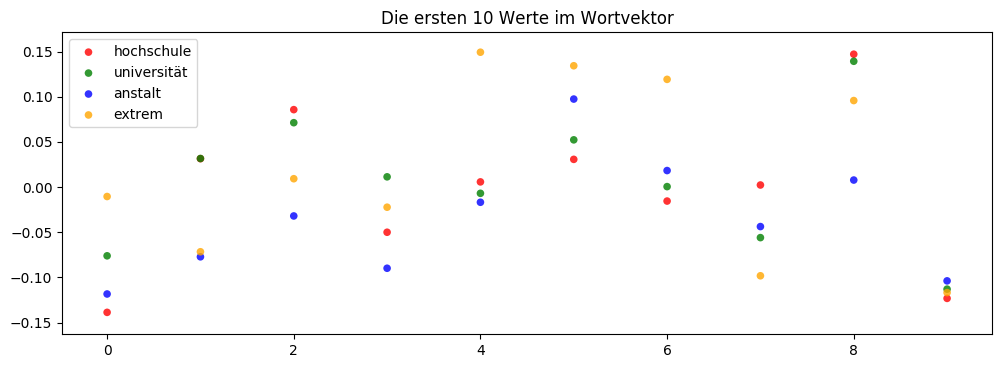

In [8]:
import matplotlib.pyplot as plt
#get vectors
vector1 = model.wv['hochschule'][:10]
vector2 = model.wv['universität'][:10]
vector3 = model.wv['anstalt'][:10]
#vergleich
vector4 = model.wv['extrem'][:10]

data = (vector1, vector2, vector3,vector4)
colors = ("red", "green", "blue", "orange")
groups = ('hochschule', 'universität', 'anstalt','extrem')

# Create plot
fig = plt.figure(figsize=(12,4),dpi=100)
ax = fig.add_subplot(1, 1, 1)

for data, color, group in zip(data, colors, groups):
    ax.scatter([range(10)], data, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Die ersten 10 Werte im Wortvektor')
plt.legend(loc=2)
plt.show()

**Expectation:**
The vectors of the words 'university' and 'college' are represented by similar vectors.
Since the meaning of the word 'institution' is more ambiguous, we expect the corresponding vector to be more divergent.

**Observation:**
As expected, the cosine similarity between 'university' and 'college' is the largest, while the comparison with 'institution' shows a larger deviation.
As a comparison, we have additionally given the similarity to the word 'extreme'. As expected, this word has the lowest similarity with the others.
For a better visualization we use the scatter plot, which shows the first 10 values of the respective word vectors.

We display the words (not the word-vectors) at indices 0 to 49 of the Word-embedding. What do we observe?

In [9]:
print(list(model.wv.vocab.keys())[:49])

['julia', 'reid', '*', '16', 'juli', '1952', 'in', 'london', 'ist', 'eine', 'britische', 'politikerin', 'der', 'brexit-partei', 'und', 'abgeordnete', 'im', 'europäischen', 'parlament', 'sie', 'gehört', 'fraktion', 'europa', 'freiheit', 'direkten', 'demokratie', 'an', 'studierte', 'biochemie', 'universität', 'bath', 'nach', 'dem', 'studium', 'war', 'als', 'wissenschaftliche', 'mitarbeiterin', 'tätig', '1998', 'promovierte', 'auf', 'gebiet', 'pharmakologie', 'dann', 'des', 'diabetes', 'and', 'lipid']


At the first words in the model we can read the first article with which the word embedding was tainted.
Words seem to be added sequentially to the word vector, if the respective word is not yet part of the model.

### Analyse Word Similarities

In [10]:
model.init_sims(replace=True)#create an index for similarity calculations

#### Step 6: Most similar words
For a German word of our choice, we display the 20 most similar words. Lets choose the word nice = nett

In [11]:
w1='nett'
print(model.wv.most_similar(positive=w1, topn=20))

[('liebenswert', 0.762053906917572), ('altklug', 0.7606230974197388), ('gesprächig', 0.7469647526741028), ('bezaubernd', 0.7446980476379395), ('spießig', 0.7431972026824951), ('brav', 0.7424725294113159), ('anzuschauen“', 0.7409018874168396), ('dumm', 0.7399777173995972), ('gutherzig', 0.7393226623535156), ('geschwätzig', 0.7370902895927429), ('selbstverliebt', 0.7326505780220032), ('umwerfend', 0.7314393520355225), ('anständig', 0.7305387258529663), ('herzensgut', 0.7300658226013184), ('rüpelhaft', 0.7297646403312683), ('leichtlebig', 0.7294158339500427), ('dämlich', 0.7293797731399536), ('gelaunt', 0.7290012240409851), ('dickköpfig', 0.7275737524032593), ('ungezogen', 0.7269451022148132)]


For the pairs of german words , we display their similarity-value.

In [12]:
print("Similarity of 'lindau' and 'bodensee'", model.wv.similarity("lindau", "bodensee"))
print("Similarity of 'lindau' and 'nordsee'", model.wv.similarity("lindau", "nordsee"))

Similarity of 'lindau' and 'bodensee' 0.7704846
Similarity of 'lindau' and 'nordsee' 0.34071928


For two sets of German words of our choice, we display their similarity-value.

In [13]:
sim = model.wv.n_similarity(['frankreich', 'österreich', 'tschechien'], ['deutschland'])
print(round(sim,2))

0.76


#### Step 7: Word Relations
We apply the Word Embedding in order to answer the following questions:
* *Mann is to König as Frau is to ?*
* *Paris is to Frankreich as Berlin is to ?*
* *Student is to Hochschule as Arbeiter is to ?*

In [14]:
print("Mann is to König as Frau is to:", model.wv.most_similar(positive=['frau', 'könig'], negative=['mann'])[0][0])
print("Paris is to Frankreich as Berlin is to:", model.wv.most_similar(positive=['frankreich', 'berlin'], negative=['paris'])[0][0])
print("Student is to Hochschule as Arbeiter is to:", model.wv.most_similar(positive=['hochschule', 'arbeiter'], negative=["student"])[0][0])

Mann is to König as Frau is to: gemahlin
Paris is to Frankreich as Berlin is to: deutschland
Student is to Hochschule as Arbeiter is to: fabriken


#### Step 8: Outliers
We apply the Word Embedding in order to determine the outlier within the following set of words: *auto, motorrad, kran, essen*. 

In [15]:
print("Outlier in [auto, motorrad, kran, esssen]:", model.wv.doesnt_match(['auto','motorrad','kran','essen']))

Outlier in [auto, motorrad, kran, esssen]: essen


/home/pia3/.direnv/python-3.7.3rc1/lib/python3.7/site-packages/gensim/models/keyedvectors.py:858: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


### Visualize Word Embeddings
The following code-cell visualizes similarities of words from index 300 to 599 by transforming the high-dimensional word-vectors into a 2-dim space. The transformation is realized by [scikit-learn's TSNE modul](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


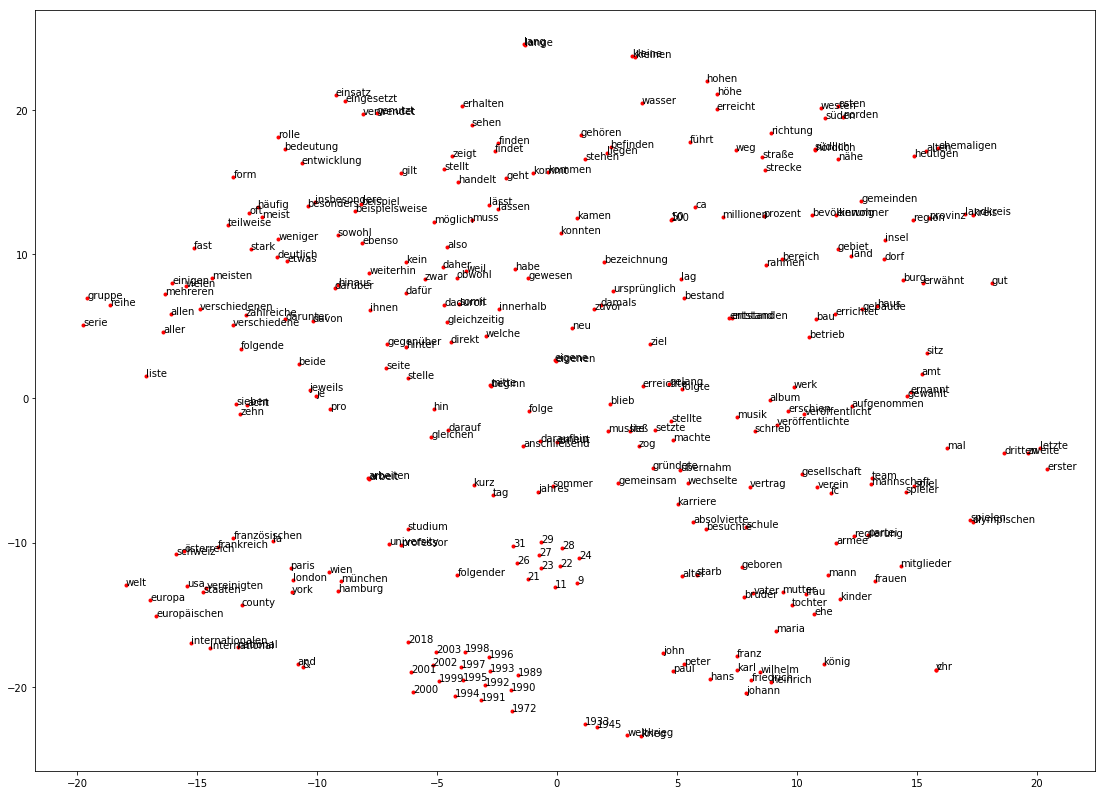

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
tsneModel=TSNE(n_components=2,random_state=0)
np.set_printoptions(suppress=True)
model2d=tsneModel.fit_transform(model[model.wv.index2word[300:600]])


plt.figure(figsize=(19,14))
idx=0
for a in model2d[:300]:
    #w=model.wv.index2word[300+idx].decode('utf-8')
    w=model.wv.index2word[300+idx]
    plt.plot(a[0],a[1],'r.')
    plt.text(a[0],a[1],w)
    idx+=1
plt.show()

#### Step 9: Visualize similarities of selected target words and their neighbors
For each of the word in the list `targetwords` we calculate the 10 nearest neighbors. Then we apply the same procedure as in the code cell above in order to visualize the similarities between all words in `wordset`, where `wordset` contains the target words and for each target word the 10 nearest neighbors. What do we observe? 

In [17]:
targetwords = ['bier', 'apfelbaum', 'student', 'uni'] #max: 7
wordsets = []

i = 0;
for word in targetwords:
    print('='*10)
    print(word)
    print('-'*5)
    wordset = (model.wv.most_similar(positive=word, topn=10))
    wordsets.append(word)
    for similar in wordset:
        print(similar[0])
        #words.append(similar[0])
        wordsets.append(similar[0])
    #wordsets.append(words)
    #wordsets.append(word)
    #print(len(wordsets[i]))
    #print(wordsets[i])
    i += 1
#print('====')
#print(wordsets)

bier
-----
gebrautes
weizenbier
gebraut
schwarzbier
gebraute
ausschenken
malzbier
ausgeschenkt
getränk
weißbier
apfelbaum
-----
feigenbaum
baum
baumstumpf
haselstrauch
weidenbaum
haselnussstrauch
rosenstrauch
grünender
lorbeerbaum
heckenrose
student
-----
jurastudent
mathematikstudent
medizinstudent
theologiestudent
jura-student
philosophiestudent
kommilitone
gymnasiast
studentin
schuljunge
uni
-----
universität
ernst-abbe-fachhochschule
tu
duisburg-essen
paris-lodron-universität
witten-herdecke
fub
philosophisch-sozialwissenschaftlichen
tud
ernst-abbe-hochschule


clouds_number 4


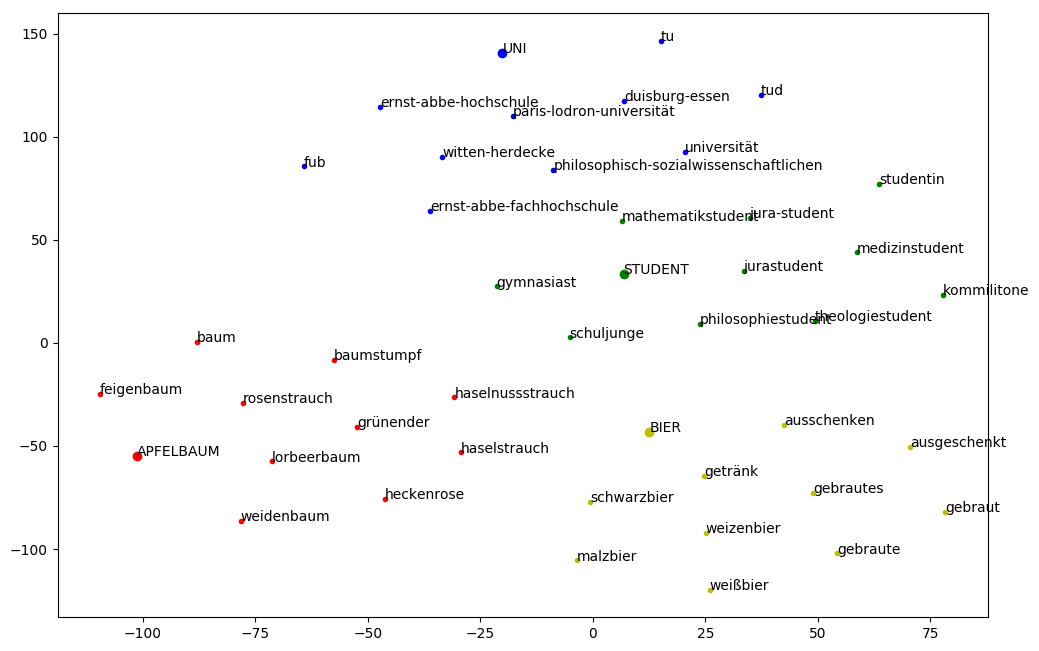

In [18]:
#visualise
tsneModel=TSNE(n_components=2,random_state=0)
np.set_printoptions(suppress=True)

clouds_number = i

wordsets2Vec = []
for word in wordsets:
    wordsets2Vec.append(model.wv[word])
model_2d=tsneModel.fit_transform(wordsets2Vec)


plt.figure(figsize=(12,8), dpi=100)
idx=0
colours = ['y', 'r', 'g', 'b', 'c', 'm', 'k']
#cloudplot = 0
wordcount=len(model_2d)
print('clouds_number ' + str(clouds_number))

for cloud in range(clouds_number):
    fraction = wordcount/clouds_number
    #print('   ' + str(fraction)+'   ' + str(cloud))
    for a in model_2d[int((cloud)*fraction):int((cloud+1)*fraction)]:
        
        w=wordsets[idx]
        
        display = colours[cloud]
        if idx % fraction == 0:#display targetwords with larger marker and all caps
            display = display + 'o'
            w = w.upper()
        else:
            display = display + '.'
        #add word to plt
        plt.plot(a[0],a[1],display)
        plt.text(a[0],a[1],w)
        idx+=1
plt.show()

Similar words are also closer to each other in the two-dimensional representation. In this example, the 10 most similar words to the words 'uni' and 'student' are also very close and form a "cloud".

----

## Steps on Text Classification

In this section a CNN document classifier shall be defined, trained and evaluated with Keras.

The classifier shall be able to distinguish RSS-feed news with technical content from general RSS-feed news. Training and evaluation data is available from the folder `./Data/GERMAN/`.  

### Access locally stored RSS-feed news of both categories 
News crawled from RSS feeds of category `Tech` and `General` are stored in distinct directories. In the following code-cell the paths to both directories are configured. 

In [19]:
techpath="./Data/GERMAN/TECH/RSS/FeedText"
generalpath="./Data/GERMAN/GENERAL/RSS/FeedText"
catpaths=[techpath,generalpath]

The specified directory `techpath` must contain a list of directories. The name of each of these directories is the name of the feed, from which the news are crawled attached by the date of crawling. For example one subdirectory may be `golem-2017-11-07`. Each of this feed-and-date-specific subdirectories conatins one or more `.txt`-files. The name of each of these `.txt`-files is of format `hh-mm.txt`, i.e. it contains the daytime of crawling. If one feed is crawled multiple times per day, the feed-and-date-specific subdirectories will contain more than one `.txt`-files, each identified by the time of crawling. Below, the first lines of a sample `.txt`-file, `15-15.txt` from directory `golem-2017-11-07` are shown. Each paragraph of the file is a single news item from the *golem RSS feed*, crawled at 2017-11-07, 15.51h.


In the following code-cell all news from all files are imported. All news from subdirectories of `techpath` are assigned to the class `Tech` (label 0) and all news from subdirectories of `generalpath` are assigned to class `GENERAL` (label 1). Each news-item is represented as a list of words, contained in the item. All item-specific word-lists are assigned to the list `texts` and the corresponding class-indices are assigned to the list `labels`. Before news-item specific word lists are appended to the `texts`-list it is checked, if they are not yet contained in this list.  

In [20]:
# second, prepare text samples and their labels
print('Processing text dataset')
texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for catlabel,categorypath in enumerate(catpaths):
    for name in sorted(os.listdir(categorypath)):
        feedpath = os.path.join(categorypath, name)
        if os.path.isdir(feedpath):
            #print(name)
            for fname in sorted(os.listdir(feedpath)):
                fpath = os.path.join(feedpath, fname)
                if sys.version_info < (3,):
                    f = open(fpath)
                else:
                    f = open(fpath, encoding='utf-8')
                t = f.read()
                news=t.split('\n \n')
                for entry in news:
                    if (len(entry)>50) and (entry not in texts): #remove duplicates
                        #if entry not in texts:
                        texts.append(entry)
                        labels.append(catlabel)
                f.close()
print('Found %s texts.' % len(texts))

Processing text dataset
Found 4012 texts.


In [21]:
print(texts[0])
print(labels[0])
print("-"*20)
print(texts[1])
print(labels[1])
print("-"*20)
print(texts[3000])
print(labels[3000])

Rossmann eröffnet 105 neue Filialen: Kommt der Drogerie-Riese auch in Ihre Stadt?
 Drogerie-Riese Rossmann will allein 2018 weitere 105 neue Filialen eröffnen. Die Firma aus dem niedersächsischen Burgwedel setzt dabei auf neue Ladenkonzepte und eine größere Einkaufsfläche.
0
--------------------
63.000 Schallplatten kostenlos: Internet-Archiv digitalisiert riesigen Musik-Schatz
 Sie mögen das Kratzen und Knarzen alter Schellackplatten? Dann wird Ihnen bei den neusten Digital-Aufnahmen des Internet Archiv das Herz aufgehen. Denn jetzt wurden weitere Platten digitalisiert, sodass jetzt insgesamt mehr als 63.000 Titel zum Download bereitstehen.
0
--------------------
Neue Zuggattung: Warum die Bahn jetzt einen ECE auf die Gleise schickt
In Deutschland verkehrt ab Dezember ein neuer Superzug zwischen Frankfurt am Main und Mailand. Die Bahn hat ihm eine neue Zuggattung gewidmet. Dabei steckt hinter dem EuroCity-Express (ECE) ein Konkurrent.
1


It is striking here that a news item about the drugstore chain Rossmann belongs to the category Tech (Label 0), although the content is not necessarily related to technology. This indicates that not all texts can be clearly assigned to a category.
This could affect the performance of our classifier.

### Convert texts to sequence of integers

#### Step 10: Transform each text into a sequence of integers
We apply the [Keras Tokenizer class](https://keras.io/preprocessing/text/#tokenizer) in order to uniquely map each word to an integer-index and to represent each text (news-item) as a sequence of integers. The maximum number of words regarded in the Tokenizer shall be `MAX_NB_WORDS=10000`. After fitting the `Tokenizer`-object with the available texts (`fit_on_texts()`), it's attribute `tokenizer.word_index` maps each word to an integer-index. 

In [22]:
## Map each word of all texts to an integer index
maxnbwords = 10000
tokenizer = Tokenizer(num_words=maxnbwords)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index #print(tokenizer.word_index)

In [23]:
## Make a list of lists representing each text as a sequence of the previously created integer indexes (insted of words) 
sequences = []
for text in texts:
    textSequence = text_to_word_sequence(text)
    integersequence = []
    for word in textSequence:
        integersequence.append(word_index[word])
    sequences.append((integersequence))
print(sequences[0])

[4831, 1311, 4832, 50, 2748, 106, 2, 6421, 4833, 23, 4, 86, 464, 6421, 4833, 4831, 38, 740, 172, 239, 4832, 50, 2748, 4834, 1, 566, 29, 21, 10197, 10198, 240, 112, 12, 50, 10199, 3, 15, 2749, 10200]


#### Step 11: Visualize distribution of document lengths
We visualize the distribution of document lengths in a histogram.

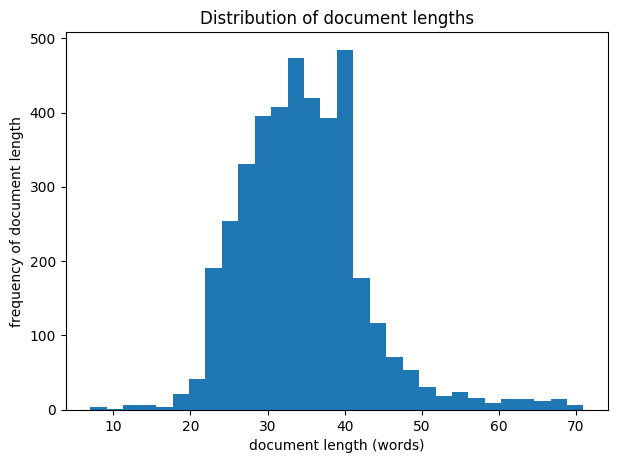

In [24]:
#print(len(texts[10:15]))
documentLengths = []
for document in texts:
    documentLengths.append(len(str.split(document)))

plt.figure(figsize=(7,5), dpi=100)
plt.hist(x=documentLengths, bins=30)
plt.gca().set(title='Distribution of document lengths', ylabel='frequency of document length', xlabel='document length (words)')
plt.show()

We can see that most of the documents have a length between 20 and 40 words. The longest document is 71 words long.

#### Step 12: Pad sequences to unique length
Next the [Keras function pad_sequences](https://keras.io/preprocessing/sequence/#pad_sequences) will be applied to represent the set of all sequences as a numpy-array. The number of rows in this array is the number of sequences, the number of columns is the fixed sequence length `maxlen`.

Moreover, the labels-list should be one-hot-encoded into a numpy-array `labels` with two columns. In this array the entry in row i, column j is 1, if the i.th text belongs to the class with label j, otherwise this entry is 0.

In [25]:
# add padding to sequences
maxlength = max(documentLengths)
sequences = pad_sequences(sequences, maxlen=maxlength)
print("First sequence:")
print(sequences[0])

First sequence:
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0  4831  1311  4832    50
  2748   106     2  6421  4833    23     4    86   464  6421  4833  4831
    38   740   172   239  4832    50  2748  4834     1   566    29    21
 10197 10198   240   112    12    50 10199     3    15  2749 10200]


In [26]:
# one hot encode labels
labelsEncoded = to_categorical(labels)
print("One hot encoded labels:")
print(labelsEncoded)

One hot encoded labels:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


### Split labeled texts in training- and validation set

#### Step 13: Create training- and validation-partition
The numpy-array of padded integer-sequences and the corresponding labels (as generated in the code cell above) should be randomly shuffled and then split into a training- and a validation set. 80% of the labeled data is applied for training, the remaining 20% for validation. 

In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split( sequences, labelsEncoded, test_size=0.2, random_state=42, shuffle=True)
print("Feature 0:", X_train[0])
print("Label 0:", y_train[0])

Feature 0: [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0  3870  2351  3095    38   744
    16  1693     1 22956    17     4    33   494 22957  2012   221    10
  1032    25  9726  9799    11  2415   167     1  1004    22  2114]
Label 0: [0. 1.]


### Load  and prepare Word-Embedding

#### Step 14: Load Word Embedding
We load the Word Embedding, which has been trained and saved in step 3.

In [28]:
wordEmbedding=word2vec.Word2Vec.load(modelName)
print("Finished loading word embedding")

Finished loading word embedding


#### Step 15: Prepare `embeddings_index`
Next a Python dictionary `embeddings_index`, which maps words to their vector-representation is generated.

In [29]:
embeddings_index={}
words = []
vectors = []
for word in tokenizer.word_index:
    
    if word in wordEmbedding.wv.vocab:
        #print(word)
        words.append(word)
        vectors.append(wordEmbedding.wv[word])
        #print(wordEmb.wv[word][:10])
        #embeddings_index[word]=wordEmb.wv[word]
        
print(len(words))
print(len(vectors))
embeddings_index = {key:value for key, value in zip(words, vectors)}
#print(embeddings_index)

21510
21510


#### Step 16:  Prepare `embeddings_matrix`

The variable `word_index` has been allocated in **Step 10**. It maps each word of the labeled documents (news) to a unique index. Now `word_index` as calculated from the labeled input documents for the classifier is combined with the `embedding_index`, which maps each word of the word-embedding (German wikipedia dump in this case) to it's vector representation. The result is the *numpy-array* `embedding_matrix`, which contains in the i.th row the vector representation of the word with index i in the `word_index`. Applying this `embedding_matrix` allows the *Keras*-module `Embedding` to map a sequence of word-indices, which represents a single news-item, to a sequence of word-vectors. 

![wordMappings](./wordMappings.png)



In [30]:
embedding_matrix = []
# Nullen hinzufügen
# word_index beginnt bei Index 1
embedding_matrix.append(np.repeat(0, wordEmbedding.wv.vector_size))

for word in word_index.keys():
    if word in wordEmbedding:
        embedding_matrix.append(wordEmbedding[word])
    else:    #wenn für Wort kein Embedding vorhanden ist: Platzhalter aus Nullen
        embedding_matrix.append(np.repeat(0, wordEmbedding.wv.vector_size))
#print(embedding_matrix[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### Define CNN architecture, train and evaluate

#### Step 17: Define CNN architecture
The `embedding_matrix`, as generated in the previous step is now be assigned to the `weights`-argument of a [Keras Embedding Layer](https://keras.io/layers/embeddings/). The Embedding Layer constitutes the input layer of the CNN. 

Following the input layer we configure cascades of `Conv1D`-layers, followed by `MaxPooling1D`-layers. We apply `relu`-activation in the conv-layers. 


After the last convolutional-layer a `GlobalMaxPooling1D`-layer is applied, followed by a dense layer with softmax-activation (for the binary classification actually a sigmoid-activation at the output would be enough).

We display a summary of this architecture by calling the `summary()`-function.

In [ ]:
model = Sequential()
#convert embedding matrix list to array
embedding_matrix_array = np.array(embedding_matrix)
print(embedding_matrix_array.shape)
print(len(embedding_matrix_array))
print(len(embedding_matrix_array[1]))

#Stacking layers:
model.add(Embedding(input_dim=len(word_index)+1, output_dim=wordEmbedding.wv.vector_size, weights=[embedding_matrix_array], input_length=maxlength))
model.add(Conv1D(filters=10, kernel_size=10, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=10, kernel_size=10, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=10, kernel_size=10, activation="relu"))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=2, activation='softmax'))

# Display a summary of this architecture by calling the summary()-function.

model.summary()

(23384, 200)
23384
200
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 71, 200)           4676800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 62, 10)            20010     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 31, 10)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 22, 10)            1010      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 10)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 10)             1010      
_______________________________________________

#### Step 18: Define Training
Hyperparameters for training a Keras model are defined by applying the `compile()`-method. We use `binary_crossentropy` as loss-function, `rmsprop` as learning-algorithm (optimizer) and `accuracy` as metric. 

In [ ]:
#Configure the learning process with .compile():
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#### Step 19:  Training and Validation
We apply the model's `fit()`-method for training and assign training- and validation- data as generated in Step 13.

After training is finished, we plot the accuracy over the epochs.

In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=32)
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)

# classes = model.predict(X_test, batch_size=128)

print(model.metrics_names[0], loss_and_metrics[0])
print(model.metrics_names[1], loss_and_metrics[1])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/5
3209/3209 [==============================] - ETA: 0s - loss: 0.3225 - acc: 0.861 - 2s 574us/step - loss: 0.3186 - acc: 0.8635
Epoch 2/5
3209/3209 [==============================] - 1s 182us/step - loss: 0.1357 - acc: 0.9489
Epoch 3/5
3209/3209 [==============================] - 1s 185us/step - loss: 0.0643 - acc: 0.9769
Epoch 4/5
3209/3209 [==============================] - 1s 191us/step - loss: 0.0305 - acc: 0.9910
Epoch 5/5
803/803 [==============================] - 0s 135us/step
loss 0.30255325544964184
acc 0.9128268992024965


### Optimization
#### Step 20: Optimize CNN Architecture
We find a good CNN configuration by varying hyperparameters, such as number of layers, number of filters, filtersizes, etc. 


In [ ]:
#use for loops for these params:
min_conv1maxpooling_layer_number=1
max_conv1maxpooling_layer_number=4
min_number_of_filters=5
max_number_of_filters=15
min_filtersize=5
max_filtersize=15

#best hyperparams:
architectureResults = []


#tripple for loop for all three params
for current_layer_number in range(min_conv1maxpooling_layer_number, max_conv1maxpooling_layer_number + 1):
    for current_number_of_filters in range(min_number_of_filters, max_number_of_filters + 1):
        for current_filtersize in range(min_filtersize, max_filtersize + 1):
            model = Sequential()
            embedding_matrix_array = np.array(embedding_matrix)
            model.add(Embedding(input_dim=len(word_index)+1, output_dim=wordEmbedding.wv.vector_size, weights=[embedding_matrix_array], input_length=maxlength))
            for x in range (0, current_layer_number +1 ):
                model.add(Conv1D(filters=current_number_of_filters, kernel_size=current_filtersize, activation="relu", padding="same"))
                model.add(MaxPooling1D(pool_size=2,padding="same"))
                #pool_size=current_filtersize
            
            model.add(Conv1D(filters=current_number_of_filters, kernel_size=current_filtersize, activation="relu",padding="same"))
            model.add(GlobalMaxPooling1D())
            model.add(Dense(units=2, activation='softmax'))

            # Display a summary of this architecture by calling the summary()-function.
            model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
            
            trained_model = model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, verbose=0)
            print("HYPERPARAMS: ", " current_layer_number: ",current_layer_number,"\n",\
                  " current_number_of_filters: ", current_number_of_filters,\
                  " current_filtersize: ", current_filtersize)
            loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
            
            print(model.metrics_names[0], loss_and_metrics[0])
            print(model.metrics_names[1], loss_and_metrics[1])
            architectureResults.append({"accuracy":  loss_and_metrics[1],\
                                   "loss": loss_and_metrics[0],\
                                   "layer_number": current_layer_number, \
                                   "number_of_filters": current_number_of_filters, \
                                    "filtersize":current_filtersize })

print("hyperparameter testing done!")

HYPERPARAMS:   current_layer_number:  1 
  current_number_of_filters:  5  current_filtersize:  5
803/803 [==============================] - 0s 150us/step
loss 0.2338093022721939
acc 0.9227895393021228
HYPERPARAMS:   current_layer_number:  1 
  current_number_of_filters:  5  current_filtersize:  6
803/803 [==============================] - 0s 171us/step
loss 0.21705560414944017
acc 0.931506849389296
HYPERPARAMS:   current_layer_number:  1 
  current_number_of_filters:  5  current_filtersize:  7
803/803 [==============================] - 0s 196us/step
loss 0.2685319695431521
acc 0.9190535492647629
HYPERPARAMS:   current_layer_number:  1 
  current_number_of_filters:  5  current_filtersize:  8
803/803 [==============================] - 0s 212us/step
loss 0.34030013574127244
acc 0.900373599152191
HYPERPARAMS:   current_layer_number:  1 
  current_number_of_filters:  5  current_filtersize:  9
803/803 [==============================] - 0s 228us/step
loss 0.26277427976558987
acc 0.92029887935

In [35]:
print(len(architectureResults))

sortedaccuracies = sorted(architectureResults, key = lambda k:k['accuracy'])
print("10 best accuracies", sortedaccuracies[len(sortedaccuracies)-10:len(sortedaccuracies)])
sortedlosses = sorted(architectureResults, key = lambda k:k['loss'])
print("10 best losses", sortedlosses[:10])

210
10 best accuracies [{'accuracy': 0.9290161892901619, 'loss': 0.251396740551291, 'layer_number': 2, 'number_of_filters': 7, 'filtersize': 12}, {'accuracy': 0.9290161892901619, 'loss': 0.3454248203848434, 'layer_number': 2, 'number_of_filters': 9, 'filtersize': 15}, {'accuracy': 0.9290161893643893, 'loss': 0.26853895737588923, 'layer_number': 2, 'number_of_filters': 12, 'filtersize': 11}, {'accuracy': 0.9302615193026152, 'loss': 0.25676760955448097, 'layer_number': 2, 'number_of_filters': 6, 'filtersize': 14}, {'accuracy': 0.9302615193768426, 'loss': 0.3143091591522747, 'layer_number': 2, 'number_of_filters': 10, 'filtersize': 11}, {'accuracy': 0.931506849389296, 'loss': 0.21705560414944017, 'layer_number': 1, 'number_of_filters': 5, 'filtersize': 6}, {'accuracy': 0.931506849389296, 'loss': 0.2232143881117199, 'layer_number': 2, 'number_of_filters': 5, 'filtersize': 9}, {'accuracy': 0.931506849389296, 'loss': 0.2482732876086814, 'layer_number': 2, 'number_of_filters': 5, 'filtersize'

The best configuration for testaccuracy results with the following configuration:
* min_conv1maxpooling_layer_number: 2
* filter size: 13
* Number of filters: 9

With this configuration we get a loss of 0.259 and a test accuracy of 0.936.

## Further ideas
If no embedding_matrix is assigned to the `weights`-argument of the `EmbeddingLayer` and the `trainable`-argument is set to be `True`, then the weights of the EmbeddingLayer are learned during training of the entire network. I.e. in this case no pre-trained word-embedding is required. It would be nice to compare this approach with the approach where pre-trained weights are applied. 

As an alternative to the CNN a LSTM-architecture, e.g. a single LSTM-Layer, followed by Dropout and a Dense Layer at the output, can be applied for classification. The input-embedding layer would be the same as for the CNN. 

In [31]:
#Alternative LSTM-architecture:
model = Sequential()
#convert embedding matrix list to array
embedding_matrix_array = np.array(embedding_matrix)

#Stacking layers:
model.add(Embedding(input_dim=len(word_index)+1, output_dim=wordEmbedding.wv.vector_size, input_length=maxlength))
model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0))
model.add(Dense(units=2, activation='softmax'))

# Display a summary of this architecture by calling the summary()-function.
model.summary()

#Configure the learning process with .compile():
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32)
# Evaluate model, print loss and accuracy
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
print(model.metrics_names[0], loss_and_metrics[0])
print(model.metrics_names[1], loss_and_metrics[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 71, 200)           4676800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 4,744,770
Trainable params: 4,744,770
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
3209/3209 [==============================] - 10s 3ms/step - loss: 0.4504 - acc: 0.7872
Epoch 2/5
3209/3209 [==============================] - 8s 3ms/st

This simple LSTM architecture already delivers high accuracy. The significantly higher training time compared to the CNN is noticeable.